---
# COSC2753 | Machine Learning

## Week 8 Lab Exercises: Deep Learning
---

## Introduction

In this lab you will be:

1. Learning how to use Keras API (in tensorflow library).
2. Implement deep NN to classify images in the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

This lab can be run either on local machine (anaconda), AWS or Google Colab. Instruction on running a notebook on Google Colab is available at: [Instructions on using Google Colab](https://rmit.instructure.com/courses/79534/files/17891673?wrap=1). If you are on Colab, make sure you add a GPU to the notebook so that the code will run faster.

### Dataset

We will be using the CIFAR-10 dataset we used last week with Neural Networks.


---

## Reading the data

Read the CIFAR 10 data and generate train/test/val split.


**Google Colab:** If you are using google colab for this lab run the following 3 blocks to load the data. Also make sure you activate the GPU using the instructions on canvas [Instructions on using Google Colab](https://rmit.instructure.com/courses/79534/files/17891673?wrap=1).

**Local Machine or AWS:** If on local machine or on AWS, comment the following 3 code blocks.


In [1]:
# from google.colab import drive

# drive.mount("/content/drive")

In [2]:
# Change according to your directory structure
# !ls /content/drive/'My Drive'/COSC2753/Lab/Week8

In [3]:
# Change according to your directory structure
# !cp /content/drive/'My Drive'/COSC2753/Lab/Week8/CIFAR10.zip .
# !unzip -q -o CIFAR10.zip
# !rm CIFAR10.zip
# !ls

Running a deep CNN model on our full dataset can be time consuming. Since we are only interested in learning the basics, you can use only a subset of data. Uncomment the two lines after the comment to select a subset of data that include only cats and dogs (2 classes).


In [4]:
import zipfile

with zipfile.ZipFile("./CIFAR10.zip", "r") as zip_ref:
    zip_ref.extractall("./")

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv("./CIFAR_Data.csv")

OUTPUT_CLASSES = 10

# Uncomment the following line to do two class classification with
# a subset of data
# data = data[(data['Class'] == 3) | (data['Class'] == 5)]
# OUTPUT_CLASSES = 2

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print(
    "Train data : {}, Val Data: {}, Test Data: {}".format(
        train_data.shape[0], val_data.shape[0], test_data.shape[0]
    )
)

Train data : 6000, Val Data: 2000, Test Data: 2000


Create the data generator for each split:


In [6]:
train_data["Class"] = train_data["Class"].astype("str")
val_data["Class"] = val_data["Class"].astype("str")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")
val_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory="./",
    x_col="ImgPath",
    y_col="Class",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory="./",
    x_col="ImgPath",
    y_col="Class",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 6000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


---

## Model Development

As discussed in Week 4-5, the typical ML model development process consists of 4 steps, lets go through each and see how it is done.

1. **Determine Your Goals**: Performance metric and target value. Problem dependent.

2. **Setup the Experiment**: Setup the test/validation data, visualisers and debuggers needed to determine bottlenecks in performance (overfitting/under-fitting, feature importance).

3. **Default Baseline Model**: Identify the components of end-to-end pipeline including - Baseline Models, cost functions, optimisation.

4. **Make Incremental Changes**: Repeatedly make incremental changes such as gathering new data, adjusting hyper-parameters, or changing algorithms, based on specific findings from your instrumentation.


### Determine Your Goals

So far we conducted the EDA (task in last weeks lab) and accordingly we can decide that a performance measure such as Accuracy is adequate for this task. This is justified by the observation that there is no label imbalance in our dataset and the task is multi-class classification. According to the CIFAR website others have achieved around 82% accuracy for the full dataset. Therefore we can set that as the target performance value. However this might be unrealistic given:

- We are only using a subset of data in this lab (10000/50000) to train the model.

**For a Deep CNN the 70% accuracy target will be more realistic.**


### Setup the Experiment

We have also identified the train/test/val splits and ready to do the experiments. In developing a neural network, we can use the learning curves to identify the next action to take. so let’s write a simple function to plot the learning curve of a NN training process. This will be our diagnostic tool.


In [8]:
import matplotlib.pyplot as plt


def plot_learning_curve(
    train_loss, val_loss, train_metric, val_metric, metric_name="Accuracy"
):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, "r--")
    plt.plot(val_loss, "b--")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(train_metric, "r--")
    plt.plot(val_metric, "b--")
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(["train", "val"], loc="upper left")

    plt.show()

### Default Baseline Model

Next step is to establish a base model. There are several popular network architectures for image classification task. They include: VGG, GoogLeNet & ResNet. While ResNet is currently the most popular architecture, implementing it as a novice to NN, can be challenging. Therefore wee will select the VGG network as our base model. You may later try to adapt ResNet for this task in your own time.

Reference: [VGG paper](https://arxiv.org/abs/1409.1556)

The VGG network was originally designed for classifying large images (with resolution around 224x224). However our images are much smaller (32x32). _Can we adapt VGG to suite our situation?_

If you study the structure of the VGG, you will notice that it consists of many blocks (A block consists of: convolution + activation + pooling). Those blocks will lead to downscaling of the image due to the use of the max pooling layer. In the original VGG, there are many such blocks because the input image size is 224x224. What we can do is use only a few VGG blocks to construct the network.


Lets start with a base model with only three VGG blocks:


In [9]:
import tensorflow as tf


model_VGG_1 = tf.keras.Sequential(
    [
        # VGG block 1
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)
        ),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

**Observations:**

- VGG has 3x3 convolution kernels only.
- Pooling is always max-pooling and they are (2x2).
- Padding is same - No boarder pixels lost when applying convolutions.
- Activation is ReLU.


Lets compile the model and fit:


In [10]:
model_VGG_1.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["categorical_accuracy"],
)

In [11]:
history_VGG_1 = model_VGG_1.fit(
    train_generator, validation_data=validation_generator, epochs=25, verbose=0
)

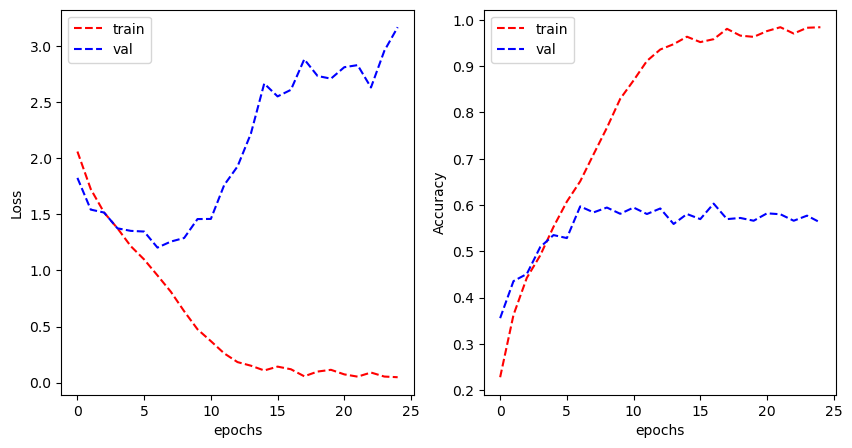

In [12]:
plot_learning_curve(
    history_VGG_1.history["loss"],
    history_VGG_1.history["val_loss"],
    history_VGG_1.history["categorical_accuracy"],
    history_VGG_1.history["val_categorical_accuracy"],
    metric_name="Accuracy",
)

❓ What do you observe?

❓ How can you rectify the issues in the above model?


### Make Incremental Changes

Based on the observations we can now take appropriate actions. The above plots show that the model is overfitting. What are the appropriate actions?

We can use any of the above techniques or a combination:

- Weight regularisation
- Dropout
- Removing layers or reducing number of kernels (making the model simple)
- Data Augmentation
- Gathering more data
- etc

Let's start by applying some weight regularisation and dropout.


In [13]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential(
    [
        # VGG block 1
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
            input_shape=(32, 32, 3),
        ),
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # VGG block 2
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # VGG block 3
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

In [14]:
model_VGG_2.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["categorical_accuracy"],
)

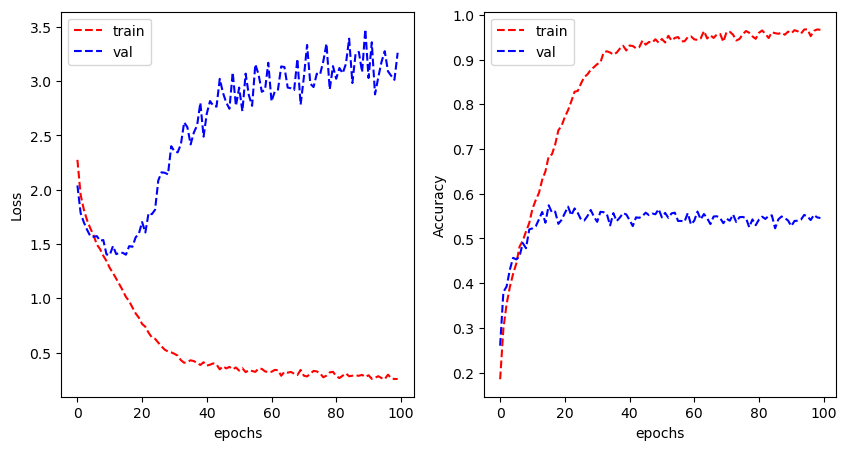

In [15]:
history_VGG_2 = model_VGG_2.fit(
    train_generator, validation_data=validation_generator, epochs=100, verbose=0
)

plot_learning_curve(
    history_VGG_2.history["loss"],
    history_VGG_2.history["val_loss"],
    history_VGG_2.history["categorical_accuracy"],
    history_VGG_2.history["val_categorical_accuracy"],
    metric_name="Accuracy",
)

**Have we solved the issue of overfitting?**

If not, what can we do?
Well we can tune the hyper-parameter reg_lambda. **This is left as an exercise for you.**


### Data Augmentation

If the model is overfitting we can use all the techniques we discussed last week to compensate for that. In addition a common technique used in deep CNN for regularisation is data augmentation.

In data augmentation, we randomly perturb the original dataset to form a larger dataset and use that for training.

The keras data generator can do this for us. However we need to pick the data augmentation techniques that are appropriate for the task. Lets see how this is done. We apply data augmentation only for training data (not for validation or test)

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Learn about available data augmentation techniques in keras [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). </font>**


In [16]:
train_data["Class"] = train_data["Class"].astype("str")
val_data["Class"] = val_data["Class"].astype("str")

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    data_format="channels_last",
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255, data_format="channels_last")

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory="./",
    x_col="ImgPath",
    y_col="Class",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory="./",
    x_col="ImgPath",
    y_col="Class",
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode="categorical",
)

Found 6000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [18]:
reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential(
    [
        # VGG block 1
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
            input_shape=(32, 32, 3),
        ),
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # VGG block 2
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.Conv2D(
            64,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        # VGG block 3
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.Conv2D(
            128,
            (3, 3),
            activation="relu",
            padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            128,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

In [19]:
model_VGG_3.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["categorical_accuracy"],
)

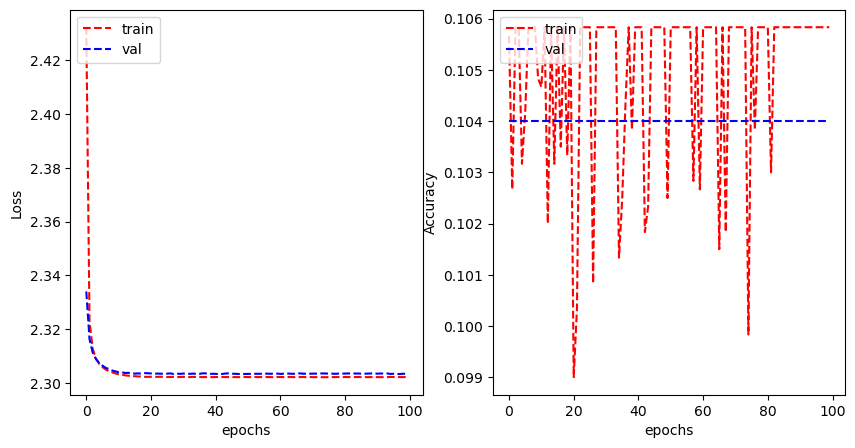

In [20]:
history_VGG_3 = model_VGG_3.fit(
    train_generator, validation_data=validation_generator, epochs=100, verbose=0
)

plot_learning_curve(
    history_VGG_3.history["loss"],
    history_VGG_3.history["val_loss"],
    history_VGG_3.history["categorical_accuracy"],
    history_VGG_3.history["val_categorical_accuracy"],
    metric_name="Accuracy",
)

Is the target achived? How can you improve the model?

Discuss with the tutor and take necessary actions.


### Saving the developed model

Ones you are happy with the model you can save the model so that it can be used later. There are two main ways to save a model

1. Save the entier model with the architecture configuration: `model.save()` & `model.load()`
2. Save only the weights of each layer: `model.save_weights()` & `model.load_weights()`


Let's use save for this example:


In [21]:
model_VGG_3.save("model_VGG_3.keras")

If you are on colab you should also transfer the saved model to the google drive. Else you may loose your work when the instance gets idle and restart.


In [22]:
## Only on colab

# Change according to your directory structure
# !cp -R ./model_VGG_3.keras /content/drive/'My Drive'/COSC2753/Lab/Week8/

**Colab Users: It is recommended that you save each intermediate model that you develop and not wait till the end to save the model.** If you save the model, then you can load it and use it, if the Colab instance gets automatically terminated or disconnected. This will prevent you from losing your work and having to do evertyhing from scratch again.


---

## Transfer learning

Another common approach used to develop deep CNN models is called transfer learning.
Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task

The process for transfers learning is as follows:

- **Select Source Model:** A pre-trained source model is chosen from available models. Many research institutions release models on large and challenging datasets that may be included in the pool of candidate models from which to choose from.
- **Reuse Model:** The model pre-trained model can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modelling technique used.
- **Tune Model:** Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.

We will not dive into transfer learning in this lab. This will be an exercise for you. A nice tutorial on transfer learning is available at [Tensorflow Tutorials](https://www.tensorflow.org/tutorials/images/transfer_learning)


---

## Pre-trained Models from Tensorflow

Tensoflow also has a library of pre-trained models that you can use. You can get more information from [Keras Applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)
